In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import hvplot.pandas
from scipy import stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import label_binarize

In [10]:
data = pd.read_csv('dataset.csv', sep=';')

# Mapping de la columna Target
status_mapping = {'Dropout': 0, 'Graduate': 1, 'Enrolled': 2}
data['Target'] = data['Target'].map(status_mapping)

# Definición de variables a analizar
y = data['Target']
X = data.drop(columns=['Target'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definición del modelo base
dt_model = DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=5, max_features=None, min_samples_leaf=2, min_samples_split=10)
rf_model = RandomForestClassifier(random_state=42, max_depth=None, max_features='sqrt', min_samples_leaf=2, min_samples_split=5, n_estimators=200, oob_score=True)

rf_model.fit(X_train, y_train)
dt_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_pred_dt = dt_model.predict(X_test)

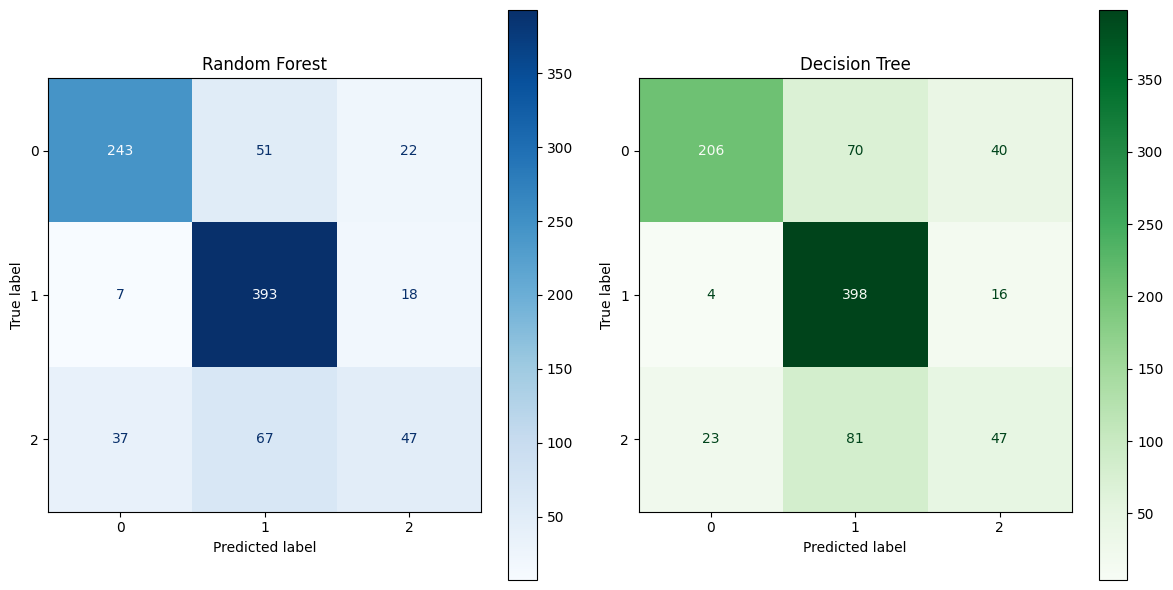

In [16]:
# Crear matrices de confusión
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_dt = confusion_matrix(y_test, y_pred_dt)

# Visualizar las matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Matriz Random Forest
ConfusionMatrixDisplay(cm_rf, display_labels=rf_model.classes_).plot(ax=axes[0], cmap='Blues')
axes[0].set_title("Random Forest")

# Matriz Decision Tree
ConfusionMatrixDisplay(cm_dt, display_labels=dt_model.classes_).plot(ax=axes[1], cmap='Greens')
axes[1].set_title("Decision Tree")

plt.tight_layout()
plt.savefig('mat_comp.pdf')
plt.show()

In [12]:
from sklearn.metrics import cohen_kappa_score

# Medir la concordancia entre las predicciones de los modelos
kappa_rf = cohen_kappa_score(y_test, y_pred_rf)
kappa_dt = cohen_kappa_score(y_test, y_pred_dt)

print(f"Cohen's Kappa - Random Forest: {kappa_rf:.2f}")
print(f"Cohen's Kappa - Decision Tree: {kappa_dt:.2f}")

Cohen's Kappa - Random Forest: 0.62
Cohen's Kappa - Decision Tree: 0.55


AUC - Random Forest: 0.89
AUC - Decision Tree: 0.85


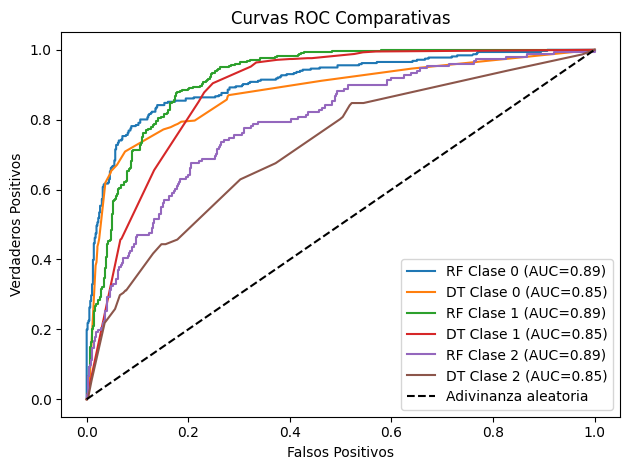

In [17]:
# Binarizar las etiquetas para curvas ROC multiclase
y_test_binarized = label_binarize(y_test, classes=rf_model.classes_)

# Calcular probabilidades predichas
y_prob_rf = rf_model.predict_proba(X_test)
y_prob_dt = dt_model.predict_proba(X_test)

# Calcular AUC para cada clase y promedio ponderado
auc_rf = roc_auc_score(y_test_binarized, y_prob_rf, average="weighted", multi_class="ovr")
auc_dt = roc_auc_score(y_test_binarized, y_prob_dt, average="weighted", multi_class="ovr")

print(f"AUC - Random Forest: {auc_rf:.2f}")
print(f"AUC - Decision Tree: {auc_dt:.2f}")

# Curvas ROC (opcional para cada clase)
for i, class_name in enumerate(rf_model.classes_):
    fpr_rf, tpr_rf, _ = roc_curve(y_test_binarized[:, i], y_prob_rf[:, i])
    fpr_dt, tpr_dt, _ = roc_curve(y_test_binarized[:, i], y_prob_dt[:, i])
    plt.plot(fpr_rf, tpr_rf, label=f'RF Clase {class_name} (AUC={auc_rf:.2f})')
    plt.plot(fpr_dt, tpr_dt, label=f'DT Clase {class_name} (AUC={auc_dt:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label="Adivinanza aleatoria")
plt.xlabel("Falsos Positivos")
plt.ylabel("Verdaderos Positivos")
plt.title("Curvas ROC Comparativas")
plt.legend()
plt.tight_layout()
plt.savefig('ROC_comp.pdf')
plt.show()

In [15]:
# Reportes de métricas
print("Random Forest Metrics:")
print(classification_report(y_test, y_pred_rf, target_names=[str(cls) for cls in rf_model.classes_]))

print("\nDecision Tree Metrics:")
print(classification_report(y_test, y_pred_dt, target_names=[str(cls) for cls in dt_model.classes_]))

Random Forest Metrics:
              precision    recall  f1-score   support

           0       0.85      0.77      0.81       316
           1       0.77      0.94      0.85       418
           2       0.54      0.31      0.39       151

    accuracy                           0.77       885
   macro avg       0.72      0.67      0.68       885
weighted avg       0.76      0.77      0.75       885


Decision Tree Metrics:
              precision    recall  f1-score   support

           0       0.88      0.65      0.75       316
           1       0.72      0.95      0.82       418
           2       0.46      0.31      0.37       151

    accuracy                           0.74       885
   macro avg       0.69      0.64      0.65       885
weighted avg       0.74      0.74      0.72       885

